# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В ходе выполнения проекта мы
* рассмотрим признаки и отберем актуальные для обучения моделей,
* тщательно изучим данные на предмет пропусков, ошибок, дубликатов и исправим найденное,
* в соответствии с моделью обработаем признаки - произведем кодирование и стандартизацию,
* выделим целевой признак и разобъем данные на выборки,
* обучим несколько моделей, подберем гиперпараметры и выберем модель наиболее подходящую под запрос заказчика.

## Импорт

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from matplotlib.cbook import boxplot_stats
import seaborn as sns

import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
import lightgbm as lgb

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

In [3]:
# отключим предупреждения Anaconda
from pylab import rcParams
import warnings
warnings.simplefilter('ignore')

# увеличим дефолтный размер графиков
rcParams['figure.figsize'] = 15, 5

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Подготовка данных

Напишем вспомогательные функции.

In [4]:
def draw_kde(column, title, xlabel):
    """ 
    График распределения для количественных величин
    """
    plt.figure(figsize=(15,6))
    plot = sns.distplot(data[column],bins=30, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

In [5]:
def draw_boxplot(column):
    """
    График распределения категориальных величин
    """
    plt.figure(figsize=(15,6))
    plot = sns.barplot(data=data.pivot_table(columns=column, values='Price', aggfunc='count'))
    plt.show()

### Загрузка и обзор

Загрузим данные и выведем первые пять строк для обзора.

In [6]:
data_path = "https://code.s3.yandex.net/datasets/autos.csv"
data = pd.read_csv(data_path)

In [7]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В датасете есть следующие признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак

* Price — цена (евро)

Посмотрим, какие типы данных встречаются в датасете и нет ли в нем пропусков.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Посмотрим процент пропусков в данных

In [9]:
(data.isna().sum()/data.shape[0]*100).round(1)

DateCrawled           0.0
Price                 0.0
VehicleType          10.6
RegistrationYear      0.0
Gearbox               5.6
Power                 0.0
Model                 5.6
Kilometer             0.0
RegistrationMonth     0.0
FuelType              9.3
Brand                 0.0
NotRepaired          20.1
DateCreated           0.0
NumberOfPictures      0.0
PostalCode            0.0
LastSeen              0.0
dtype: float64

Посмотрим распределение численных признаков.

In [10]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


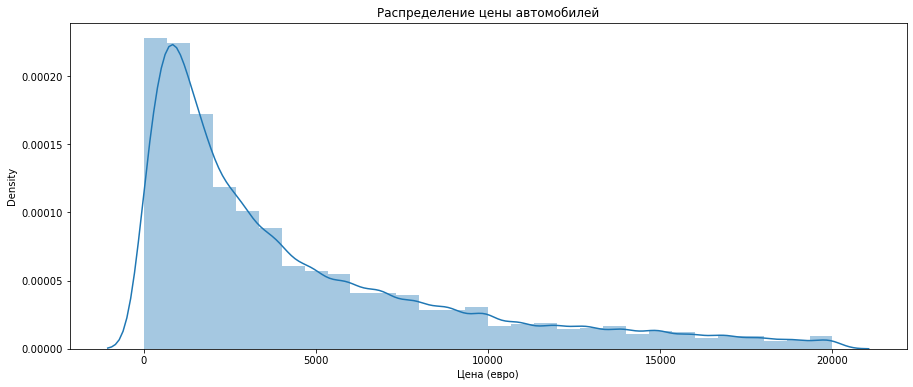

In [11]:
draw_kde('Price', 'Распределение цены автомобилей', 'Цена (евро)')

Распределение стоимости автомобилей нормальное, со скошенностью вправо, которая возникает из-за присутствия очень дорогих автомобилей. Но есть неадекватные значения равные 0, их мы учитывать в дальнейшем не будем.

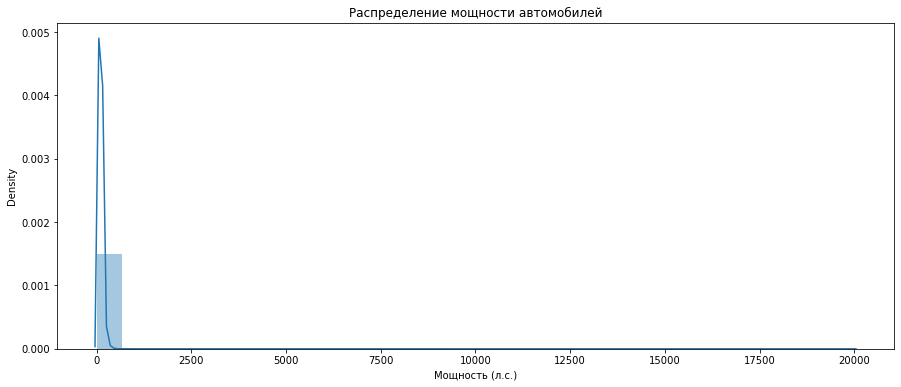

In [12]:
draw_kde('Power', 'Распределение мощности автомобилей', 'Мощность (л.с.)')

Распределение мощности очень неожиданное, максимальное количество лошадиных сил в автомобиле - 4000, здесь же указано 20000. Такие выбросы неоходимо будет убрать для продолжения работы.

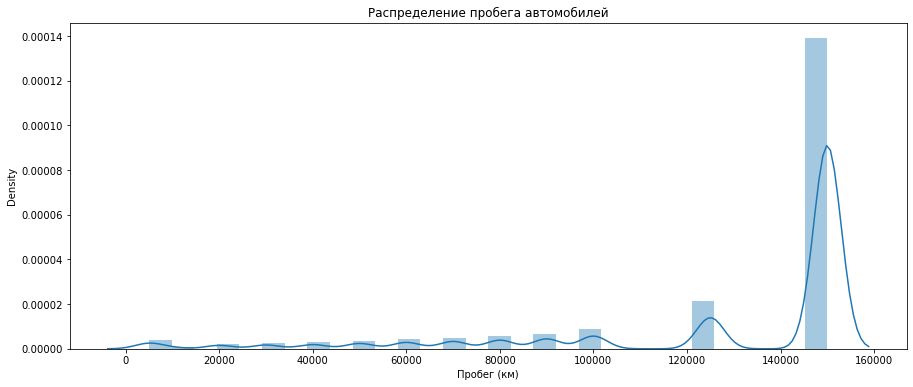

In [13]:
draw_kde('Kilometer', 'Распределение пробега автомобилей', 'Пробег (км)')

Можно заметить, что значение пробега в данном случае дискретно, видимо это особенность заполняемой при сборе информации анкеты. Максимальное значение 150000 км у подавляющего большинства объектов.

Изучим значения категориальных признаков, проверим, нет ли ошибок.

In [14]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Model', 'Brand']

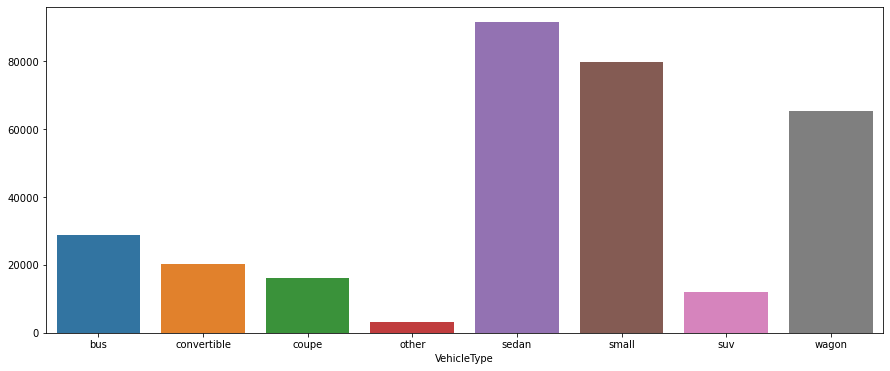

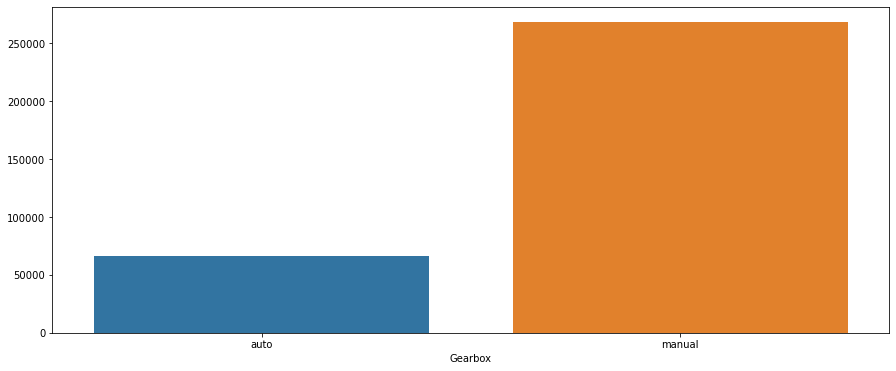

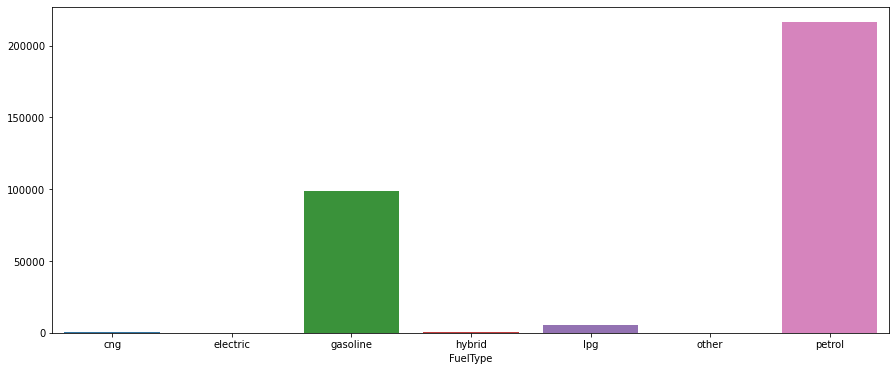

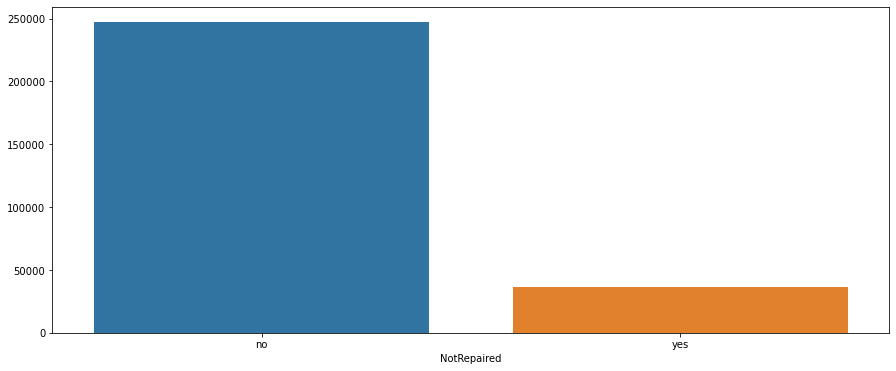

In [15]:
for feat in cat_features[:4]:
    draw_boxplot(feat)

In [16]:
for feat in cat_features[:4]:
    print(feat)
    print()
    print(data[feat].value_counts())
    print('------------------')

VehicleType

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64
------------------
Gearbox

manual    268251
auto       66285
Name: Gearbox, dtype: int64
------------------
FuelType

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64
------------------
NotRepaired

no     247161
yes     36054
Name: NotRepaired, dtype: int64
------------------


In [17]:
sorted(data['Brand'].unique())

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

In [18]:
sorted(data[~data['Model'].isna()]['Model'].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Мы загрузили и исследовали данные. Необходимо провести предобработку и выполнить следующие задачи:
* В столбцах `Price`, `Power` и `RegistrationMonth` есть значения равные нулю, необходимо их либо удалить, либо заполнить.
* В столбце `RegistrationYear` есть неверные даты, например 1000 и 9999, такого года быть не может.
* В столбце `Power` есть неверные значения, максимальное количество лошадиных сил в автомобиле - 4000, здесь же указано 20000.
* В столбце `NumberOfPictures` нет информации, все значения равны 0. Необходимо удалить столбец.
* Столбцы `DateCrawled`, `DateCreated`, `LastSeen`, `RegistrationMonth` и `PostalCode` не несут значимой информации для определения стоимости.
* В таблице довольно много пропусков, до 20%, необходимо их заполнить.
* В столбце `FuelType` есть дубликаты, petrol и gasoline это синонимы, обозначающие бензин.
* Можно снизить количество используемой памяти изменив тип данных int64 на int32 в столбце `Kilometer` и на int16 в других количествнных признаках.

### Предобработка

#### Удаление ненужных столбцов

Удалим из таблицы столбцы, не несущие значимой информации для обучения модели.

In [19]:
data.drop(['DateCrawled','LastSeen','DateCreated', 'NumberOfPictures', 'RegistrationMonth', 'PostalCode'], axis=1, inplace=True)

Проверим, что получилось.

In [20]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


#### Изменение типов данных

Уменьшим объем занимаемой таблицей памяти изменив типы данных числовых признаков.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [22]:
data['Price'] = data['Price'].astype('int16')
data['Power'] = data['Power'].astype('int16')
data['RegistrationYear'] = data['RegistrationYear'].astype('int32')
data['Kilometer'] = data['Kilometer'].astype('int16')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int16 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int32 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int16 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int16 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int16(3), int32(1), object(6)
memory usage: 19.6+ MB


Мы сократили использование памяти на 7.4 МВ

#### Заполнение пропусков

Заполним пропуски в столбцах `Gearbox`, `Model`, `FuelType` и `NotRepaired` заглушками, тк эту информацию не восстановить.

In [24]:
data[['Gearbox', 'Model', 'FuelType']].isna().sum()

Gearbox     19833
Model       19705
FuelType    32895
dtype: int64

In [25]:
data[['Gearbox', 'Model', 'FuelType']] = data[['Gearbox', 'Model', 'FuelType']].fillna('other')

In [26]:
data[['Gearbox', 'Model', 'FuelType']].isna().sum()

Gearbox     0
Model       0
FuelType    0
dtype: int64

In [27]:
data['NotRepaired'].isna().sum()

71154

In [28]:
data['NotRepaired'] = data['NotRepaired'].fillna('no_info')

In [29]:
data['NotRepaired'].isna().sum()

0

Пропуски в столбце `VehicleType` заполним используя информацию о марке и модели машины.

In [30]:
data['VehicleType'].isna().sum()

37490

In [31]:
vh_transformed = data.groupby(['Brand', 'Model'])['VehicleType'].transform(lambda x:mode(x).mode[0])

In [32]:
data['VehicleType'] = data['VehicleType'].fillna(vh_transformed)

In [33]:
data['VehicleType'].isna().sum()

0

In [34]:
(data.isna().sum()/data.shape[0]*100).round(1)

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
dtype: float64

#### Исправление ошибок

В столбце `FuelType` значения gasoline и petrol - синонимы, приведем их к одному значению.

In [35]:
data['FuelType'].replace('gasoline', 'petrol', inplace=True)

In [36]:
data['FuelType'].value_counts()

petrol      315072
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: FuelType, dtype: int64

В столбце `Power` значения мощности выходят за пределы нормальной мощности автомобиля как в меньшую, так и в большую стороны.

Посмотрим распределение с помощью графика boxplot.

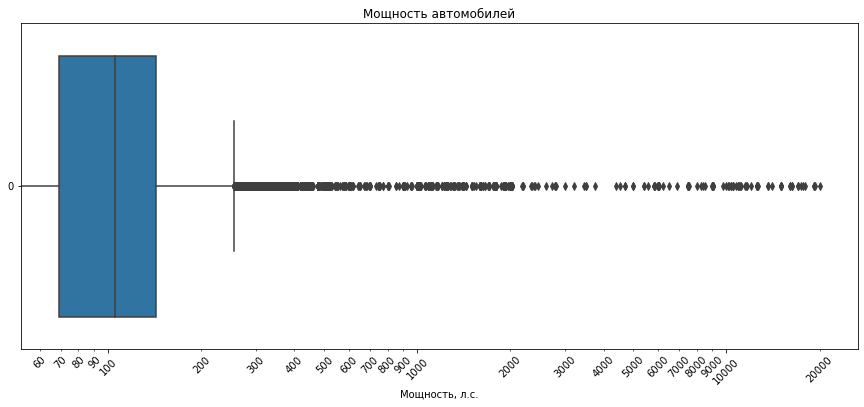

In [37]:
plt.figure(figsize=(15,6))
sns.boxplot(data=data['Power'], orient='h')
plt.xscale("log")
ax = plt.gca()
plt.tick_params(axis='x', which='minor', rotation=45)
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
plt.tick_params(axis='x', which='major', rotation=45)
ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
plt.title('Мощность автомобилей')
plt.xlabel('Мощность, л.с.')
plt.show()

На графике мы видим, что граница правого 'уса' находится примерно на 250 л.с., а левого оканчивается на нуле.

Выставим границы для отсечения аномалий. Нижний лимит возьмем чуть ближе к среднему, так как иначе из-за большого количества нулей он также равен нулю, а в данном случае это неадекватное значение.

In [38]:
upper_limit = data['Power'].quantile(0.99)
lower_limit = data['Power'].quantile(0.15)
print(lower_limit)
print(upper_limit)

54.0
300.0


Посмотрим, каков процент неадекватных значений.

In [39]:
(data[(data['Power'] < lower_limit) | (data['Power'] > upper_limit)]['Power'].count()/data.shape[0]).round(2)

0.15

Это довольно большой процент, который не хотелось бы потерять. Заменим неверные значения на самые частые для данной марки, модели и типа двигателя.

In [40]:
power_transformed = data.groupby(['Brand', 'Model', 'FuelType'])['Power'].transform('median')

In [41]:
data.loc[(data['Power'] < lower_limit) | (data['Power'] > upper_limit), 'Power'] = power_transformed

В столбце `RegistrationYear` также есть неверные даты. Так как информация собрана в 2016 году, даты позже 2016 в столбце быть не может. Нижий лимит установим по распределению и посмотрим, сколько таких дат.

In [42]:
lower_limit = data['RegistrationYear'].quantile(0.01)
print(lower_limit)

1980.0


In [43]:
(data[(data['RegistrationYear'] > 2016) | (data['RegistrationYear'] < lower_limit)]['RegistrationYear'].count()/data.shape[0]).round(2)

0.05

Аномальных дат довольно мало, всего 5%. Так как год выпуска довольно сильно влияет на стоимость автомобиля, менять эти значения не будем, а просто удалим.

In [44]:
data = data.drop(data[(data['RegistrationYear'] > 2016) | (data['RegistrationYear'] < lower_limit)].index, axis=0)

Удалим автомобили без цены.

In [45]:
(data[data['Price'] == 0]['Price'].count()/data.shape[0]).round(2)

0.03

In [46]:
data.drop(data[data['Price'] == 0].index, axis=0, inplace=True)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326652 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             326652 non-null  int16  
 1   VehicleType       326652 non-null  object 
 2   RegistrationYear  326652 non-null  int32  
 3   Gearbox           326652 non-null  object 
 4   Power             326652 non-null  float64
 5   Model             326652 non-null  object 
 6   Kilometer         326652 non-null  int16  
 7   FuelType          326652 non-null  object 
 8   Brand             326652 non-null  object 
 9   NotRepaired       326652 non-null  object 
dtypes: float64(1), int16(2), int32(1), object(6)
memory usage: 22.4+ MB


#### Удаление дубликатов

In [48]:
data.duplicated().sum()

45959

In [49]:
data = data.drop_duplicates().reset_index(drop=True)

### Разбиение на выборки и выделение целевого признака

In [50]:
y = data['Price']
X = data.drop('Price', axis=1)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.111111, random_state=42)

Проверим, что у нас получились адекватные размеры выборок.

In [52]:
X_train.shape

(224553, 9)

In [53]:
X_test.shape

(28070, 9)

In [54]:
X_val.shape

(28070, 9)

### Стандартизация

Количественные признаки стандартизируем.

In [55]:
num_features = ['RegistrationYear', 'Power', 'Kilometer']

In [56]:
scaler = StandardScaler()

In [57]:
scaler.fit(X_train[num_features])

StandardScaler()

In [58]:
X_train.loc[:, num_features] = scaler.transform(X_train[num_features])

In [59]:
X_val.loc[:, num_features] = scaler.transform(X_val[num_features])

In [60]:
X_test.loc[:, num_features] = scaler.transform(X_test[num_features])

## Обучение моделей

Мы будем сравнивать следующие модели:
* Linear Regression
* Elastic Net
* Decision Tree
* Random Forest
* CatBoost
* LightGBM
* Простая полносвязная нейросеть

Для каждого типа моделей сделаем свой датасет.

Напишем функцию для оценки и сравнения моделей.

In [61]:
def model_eval(model, X_train, y_train, X_val, y_val, model_type=None):
    
    if not model_type:
        start = time.time()    
        model.fit(X_train, y_train)
        training_time = time.time() - start
        
        start = time.time()  
        y_pred = model.predict(X_val)
        predict_time = time.time() - start

    elif model_type == 'cv':
        training_time = model.refit_time_

        start = time.time()  
        y_pred = model.predict(X_val)
        predict_time = time.time() - start
        
    rmse = (mean_squared_error(y_val, y_pred))**0.5
    
    print('Время обучения', np.round(training_time, 6), 'секунд')
    print('Время предсказания', np.round(predict_time, 6), 'секунд')
    print('RMSE', rmse)

    return training_time, predict_time, rmse

И функцию для кодирования признаков с помощью OneHotEncoderа.

In [62]:
def one_hot_transform(df, encoder):
    '''
    Кодирует данные с помощью OneHotEncoderа и встявляет их обратно в датафрейм
    '''
    global cat_features
    trans = ohenc.transform(df[cat_features]).toarray()
    df = df.drop(cat_features, axis=1)
    df = pd.concat([df, pd.DataFrame(
        trans, columns=new_columns, index=df.index)], axis='columns')
    return df

In [63]:
results = []

### Linear Regression

Для линейной регрессии и Elastic Net закодируем категориальные признаки с помощью OneHotEncoderа.

In [64]:
cat_features

['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Model', 'Brand']

In [65]:
X_train_ohe = X_train.copy()
X_val_ohe = X_val.copy()
X_test_ohe = X_test.copy()

In [66]:
ohenc = OneHotEncoder(handle_unknown='ignore')
ohenc.fit(X_train[cat_features])

OneHotEncoder(handle_unknown='ignore')

In [67]:
new_columns=list()
for col, values in zip(cat_features, ohenc.categories_):
    new_columns.extend([col + '_' + str(value) for value in values])

In [68]:
X_train_ohe = one_hot_transform(X_train, ohenc)
X_val_ohe = one_hot_transform(X_val, ohenc)
X_test_ohe = one_hot_transform(X_test, ohenc)

In [69]:
linreg = LinearRegression()

In [70]:
res = model_eval(linreg, X_train_ohe, y_train, X_val_ohe, y_val)

Время обучения 4.361902 секунд
Время предсказания 0.041578 секунд
RMSE 2783.4986705171837


In [71]:
results.append(res)

### Elastic Net

In [72]:
elnet = ElasticNet(random_state=42)

In [73]:
params = {'alpha': np.logspace(-2, 2, 20),
          'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 1]}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

el_grid = GridSearchCV(elnet,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False, refit=True)

In [74]:
%%time
el_grid.fit(X_val_ohe, y_val)

/home/alena/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20203494673.700607, tolerance: 39084699.086916104
  model = cd_fast.enet_coordinate_descent(
/home/alena/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12829523221.81482, tolerance: 38697721.889324285
  model = cd_fast.enet_coordinate_descent(
/home/alena/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17491120998.50522, tolerance: 38979866.340712585
  model = cd_fast.enet_coordinate_descent(
/home/alena/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

CPU times: user 10.5 s, sys: 490 ms, total: 11 s
Wall time: 2min 7s


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                         'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 1]},
             scoring='neg_mean_squared_error', verbose=False)

In [75]:
el_grid.refit_time_

2.004926919937134

In [76]:
res = model_eval(el_grid, X_train_ohe, y_train, X_val_ohe, y_val, 'cv')

Время обучения 2.004927 секунд
Время предсказания 0.012634 секунд
RMSE 2768.4465321621483


In [77]:
results.append(res)

### Decision Tree

Для решающего дерева, случайного леса и LightGBM закодируем категориальные признаки с помощью Ordinal Encodinga.

In [78]:
X_train_oe = X_train.copy()
X_val_oe = X_val.copy()
X_test_oe = X_test.copy()

In [79]:
ordencoder = OrdinalEncoder()

In [80]:
ordencoder.fit(X_train_oe[cat_features])

OrdinalEncoder()

In [81]:
X_train_oe[cat_features] = ordencoder.transform(X_train_oe[cat_features])
X_val_oe[cat_features] = ordencoder.transform(X_val_oe[cat_features])
X_test_oe[cat_features] = ordencoder.transform(X_test_oe[cat_features])

In [82]:
destree = DecisionTreeRegressor(random_state=42)

In [83]:
params = {'max_depth': range(1, 51, 5),
          'min_samples_split': range(2, 5),
          'min_samples_leaf': (1, 20, 3)}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

dt_grid = GridSearchCV(destree,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False, refit=True)

In [84]:
%%time
dt_grid.fit(X_val_oe, y_val)

CPU times: user 618 ms, sys: 107 ms, total: 725 ms
Wall time: 3.01 s


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 51, 5),
                         'min_samples_leaf': (1, 20, 3),
                         'min_samples_split': range(2, 5)},
             scoring='neg_mean_squared_error', verbose=False)

In [85]:
res = model_eval(dt_grid, X_train_oe, y_train, X_val_oe, y_val, 'cv')

Время обучения 0.049677 секунд
Время предсказания 0.005054 секунд
RMSE 1917.8750434979584


In [86]:
results.append(res)

### Random Forest

In [87]:
randfor = RandomForestRegressor(random_state=42, max_depth=26, min_samples_split=2, min_samples_leaf=20)

In [88]:
params = {'n_estimators': [100, 200, 300]}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(randfor,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False, refit=True)

In [89]:
%%time
grid.fit(X_val_oe, y_val)

CPU times: user 9.16 s, sys: 1.84 ms, total: 9.16 s
Wall time: 20.2 s


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(max_depth=26, min_samples_leaf=20,
                                             random_state=42),
             n_jobs=-1, param_grid={'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=False)

In [90]:
res = model_eval(grid, X_train_oe, y_train, X_val_oe, y_val, 'cv')

Время обучения 9.134307 секунд
Время предсказания 0.753534 секунд
RMSE 1881.9113099516014


In [91]:
results.append(res)

### CatBoost

In [92]:
cat = CatBoostRegressor(verbose=100, cat_features=cat_features, random_state=42)

In [93]:
res = model_eval(cat, X_train, y_train, X_val, y_val)

Learning rate set to 0.096314
0:	learn: 4311.9102571	total: 158ms	remaining: 2m 37s
100:	learn: 1852.6572282	total: 7.62s	remaining: 1m 7s
200:	learn: 1770.5486341	total: 15.2s	remaining: 1m
300:	learn: 1729.0472110	total: 22.9s	remaining: 53.2s
400:	learn: 1707.7635853	total: 30.4s	remaining: 45.4s
500:	learn: 1689.2960471	total: 38s	remaining: 37.9s
600:	learn: 1673.3909337	total: 46.1s	remaining: 30.6s
700:	learn: 1661.0505215	total: 54s	remaining: 23s
800:	learn: 1651.6678406	total: 1m 1s	remaining: 15.4s
900:	learn: 1643.2830099	total: 1m 9s	remaining: 7.66s
999:	learn: 1634.3206002	total: 1m 17s	remaining: 0us
Время обучения 78.610898 секунд
Время предсказания 0.080654 секунд
RMSE 1688.1682491847394


In [94]:
results.append(res)

### LightGBM

In [95]:
lgbregr = lgb.LGBMRegressor()

In [96]:
lgb_params = {
    'boosting_type' : ['dart', 'gbdt', 'goss'],
    'max_depth': [15, 30],
    'num_leaves': [10, 100, 200]
}
lgb_gs = GridSearchCV(lgbregr, lgb_params, scoring='neg_mean_squared_error', n_jobs=-1, refit=True)
lgb_gs.fit(X_train_oe, y_train)

GridSearchCV(estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['dart', 'gbdt', 'goss'],
                         'max_depth': [15, 30], 'num_leaves': [10, 100, 200]},
             scoring='neg_mean_squared_error')

In [97]:
lgb_gs.best_estimator_

LGBMRegressor(boosting_type='goss', max_depth=30, num_leaves=200)

In [98]:
res = model_eval(lgb_gs, X_train_oe, y_train, X_val_oe, y_val,'cv')

Время обучения 1.547521 секунд
Время предсказания 0.111741 секунд
RMSE 1655.9354311911457


In [99]:
results.append(res)

### Нейросеть

Для нейросети данные надо преобразовать в тензоры из которых создать датасеты и загрузить их в даталоадеры для загрузки данных батчами.

In [100]:
X_train_t = torch.FloatTensor(X_train_ohe.values)
y_train_t = torch.FloatTensor(y_train.values)

In [101]:
X_val_t =  torch.FloatTensor(X_val_ohe.values)
y_val_t =  torch.FloatTensor(y_val.values)

In [102]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=256)
val_dataloader = DataLoader(val_dataset, batch_size=256)

In [103]:
activation = nn.ReLU

model = nn.Sequential(
    nn.Linear(311, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 1)
)

In [104]:
loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters())

In [105]:
start = time.time() 
# Run the training loop
for epoch in range(0, 10): # 10 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_dataloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        model.train()
      
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = model(inputs)
    
        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()
      
        # Perform optimization
        optimizer.step()

training_time = time.time() - start        
        
# Process is complete.
print('Training process has finished.')

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Training process has finished.


In [106]:
start = time.time()  
model.eval()
with torch.no_grad():
    pred = model(X_val_t)
predict_time = time.time() - start    
mse = (mean_squared_error(y_val, pred))**0.5

In [107]:
res = (training_time, predict_time, mse)

In [108]:
results.append(res)

## Оценка результатов

In [109]:
def show_res(column, title):
    plt.figure(figsize=(12,6))
    plot = sns.barplot(x=result_table.index, y=result_table[column])
    plt.title(title)
    plt.show()

Выведем полученные результаты в виде таблицы и графиков и сравним.

In [110]:
result_table = pd.DataFrame(data=results,
                            index=['LinearRegression', 'ElasticNet', 'DecisionTree',
                                   'RandomForest', 'CatBoost', 'LightGBM', 'FCNN'],
                            columns=['trainig_time', 'prediction_time', 'score'])
result_table

,trainig_time,prediction_time,score
LinearRegression,4.361902,0.041578,2783.498671
ElasticNet,2.004927,0.012634,2768.446532
DecisionTree,0.049677,0.005054,1917.875043
RandomForest,9.134307,0.753534,1881.911310
CatBoost,78.610898,0.080654,1688.168249
LightGBM,1.547521,0.111741,1655.935431
FCNN,32.753158,0.045762,1850.827923


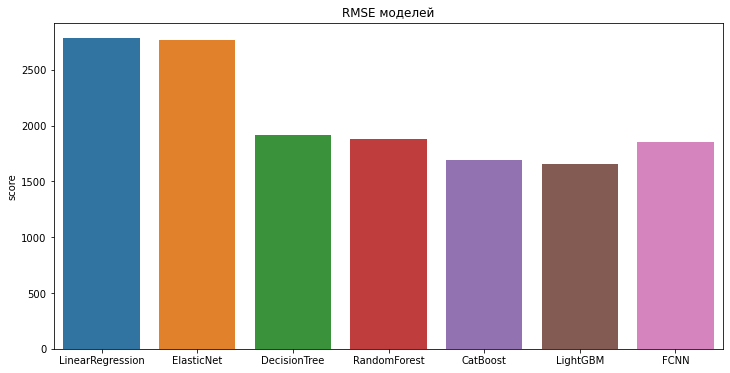

In [111]:
show_res('score', 'RMSE моделей')

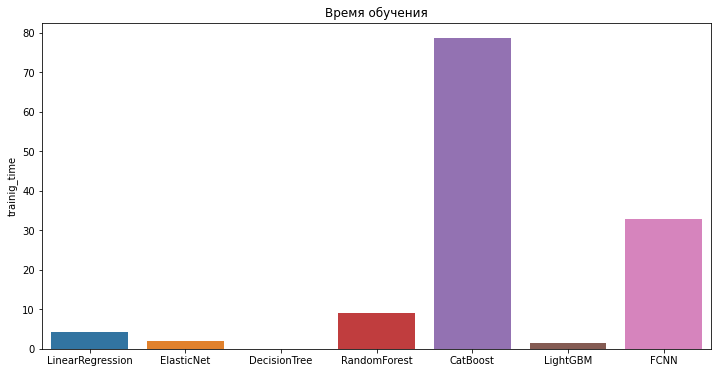

In [112]:
show_res('trainig_time', 'Время обучения')

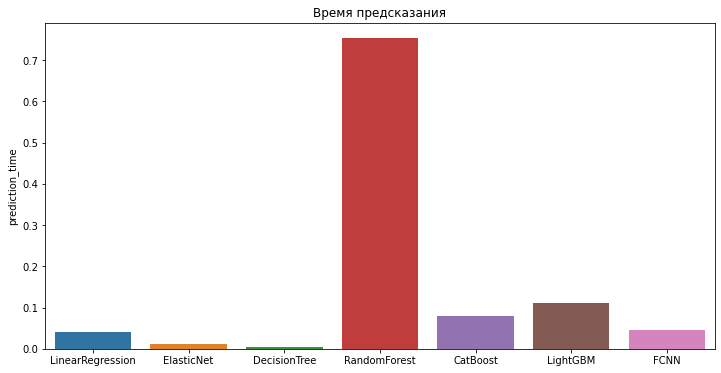

In [113]:
show_res('prediction_time', 'Время предсказания')

Выбирая лучшую модель, отталкиваемся от задачи. Заказчику важны:
* качество предсказания;
* скорость предсказания;
* время обучения.

Мы видим, что первые две модели Linear Regression и Elastic Net дают значительно худшее качество, чем другие модели. Модель Random Forest дает достаточно хорошее качество, но обучается очень медленно, так как заказчику важно время предсказания, эту модель мы отбрасываем. Из оставшихся моделей можно выбирать. Лучшее качество и скорость обучения у модели LightGBM Regressor и именно ее мы бы рекомендовали в качестве главного варианта.

## Финальное тестирование

Переобучим выбранную модель на объединенных обучающей и валидирующей выборках и протестируем на тестовой выборке.

In [114]:
X = pd.concat([X_train_oe, X_val_oe])
y = pd.concat([y_train, y_val])

In [115]:
lgb_gs.best_estimator_.fit(X, y)

LGBMRegressor(boosting_type='goss', max_depth=30, num_leaves=200)

In [116]:
pred = lgb_gs.best_estimator_.predict(X_test_oe)
mse = (mean_squared_error(y_test, pred))**0.5

In [117]:
print('Финальное качество модели', mse)

Финальное качество модели 1660.5947840088386
